Machine Learning
UE22CS352A
Orange Problem Statement

NAME : Raashi Bafna
SRN : PES2UG22CS422
SEM : 5
SEC : G

1) Installing and Importing Required Libraries

In [22]:
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold,cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_recall_fscore_support 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


2) Defining Emotions

In [3]:
emotion_dict = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

3) Feature Extraction

In [24]:
# Base directory containing all actor subfolders
base_dir = 'speech-emotion-recognition-ravdess-data'

# Initialize an empty list to store the extracted features and metadata
features = []

# Loop through the folder of every actor
for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    
    # Check if it is a directory
    if os.path.isdir(actor_path):
        print(f"Processing {actor_folder}...")

        # Loop through each audio file in the actor's folder
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)
            
            # Load the audio file
            y, sr = librosa.load(audio_path)
            
            #1)Extract MFCC features (flatten for storage)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1)
            
            #2) Extract Chromagram (flatten for storage)
            chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = np.mean(chromagram, axis=1)
            
            #3) Extract Mel-scaled Spectrogram (flatten for storage)
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
            
            #4) Extract Spectral Contrast (flatten for storage)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
            
            #5) Extract Tonnetz (flatten for storage)
            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            tonnetz_mean = np.mean(tonnetz, axis=1)
            
            # Append the extracted features and metadata to the list
            features.append([
                actor_folder,  # Actor ID
                audio_file,  # Audio file name
                *mfccs_mean,  # Flattened MFCC mean
                *chroma_mean,  # Flattened Chromagram mean
                *mel_spectrogram_mean,  # Flattened Mel-scaled Spectrogram mean
                *spectral_contrast_mean,  # Flattened Spectral Contrast mean
                *tonnetz_mean  # Flattened Tonnetz mean
            ])

# Define column names for the CSV file
mfcc_cols = [f'mfcc_{i+1}' for i in range(13)]
chroma_cols = [f'chroma_{i+1}' for i in range(12)]
mel_cols = [f'mel_{i+1}' for i in range(128)]  # Default 128 mel bands
spectral_contrast_cols = [f'spectral_contrast_{i+1}' for i in range(7)]  # Default 7 spectral bands
tonnetz_cols = [f'tonnetz_{i+1}' for i in range(6)]  # Default 6 tonal dimensions

# Create a DataFrame to store the features
columns = ['Actor', 'Audio_File'] + mfcc_cols + chroma_cols + mel_cols + spectral_contrast_cols + tonnetz_cols
df_features = pd.DataFrame(features, columns=columns)

# Save the DataFrame to a CSV file
output_csv = 'extracted_audio_features.csv'
df_features.to_csv(output_csv, index=False)

print(f"Extraction  of features is completed. Data saved to the file {output_csv}")

Processing Actor_01...
Processing Actor_02...
Processing Actor_03...
Processing Actor_04...
Processing Actor_05...
Processing Actor_06...
Processing Actor_07...
Processing Actor_08...
Processing Actor_09...
Processing Actor_10...
Processing Actor_11...
Processing Actor_12...
Processing Actor_13...


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


Processing Actor_14...
Processing Actor_15...
Processing Actor_16...
Processing Actor_17...
Processing Actor_18...
Processing Actor_19...
Processing Actor_20...
Processing Actor_21...
Processing Actor_22...
Processing Actor_23...
Processing Actor_24...
Extraction  of features is completed. Data saved to the file extracted_audio_features.csv


4) Balancing the Dataset

In [46]:
# Load the features DataFrame from the CSV
df_features = pd.read_csv('extracted_audio_features.csv')

# Extract Emotion from Audio_File assuming the emotion is encoded in the filename
df_features['Emotion'] = df_features['Audio_File'].apply(lambda x: x.split('-')[2])

# 1. Count Samples for Each Emotion
emotion_counts = df_features['Emotion'].value_counts()
print("Emotion Counts:")
print(emotion_counts)

# 2. Find the minimum number of samples per emotion
min_samples = emotion_counts.min() 
print(f"Minimum number of samples per emotion: {min_samples}")

# 3. Select Samples to Balance the Dataset
target_samples = 192
df_balanced = df_features.groupby('Emotion').apply(lambda x: x.sample(n=target_samples, replace=True)).reset_index(drop=True)

# Print the balanced dataset size
print(f"Balanced dataset size: {df_balanced.shape}")

# 4. Count Samples After Balancing
balanced_emotion_counts = df_balanced['Emotion'].value_counts()
print("Balanced Emotion Counts:")
print(balanced_emotion_counts)

# Save the balanced dataset to a new CSV file
output_balanced_csv = 'balanced_audio_features.csv'
df_balanced.to_csv(output_balanced_csv, index=False)

print(f"Balanced dataset saved to {output_balanced_csv}")

Emotion Counts:
Emotion
02    192
03    192
04    192
05    192
06    192
07    192
08    192
01     96
Name: count, dtype: int64
Minimum number of samples per emotion: 96
Balanced dataset size: (1536, 169)
Balanced Emotion Counts:
Emotion
01    192
02    192
03    192
04    192
05    192
06    192
07    192
08    192
Name: count, dtype: int64
Balanced dataset saved to balanced_audio_features.csv


5) Splitting the Data

In [47]:
# Load the balanced dataset from the CSV
df_balanced = pd.read_csv('balanced_audio_features.csv')

# Split the dataset into features and labels
X = df_balanced.drop(columns=['Actor', 'Audio_File', 'Emotion'])  # Features
y = df_balanced['Emotion']  # Labels

# 1. Split the dataset into training and testing subsets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Print the sizes of the resulting datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_data.to_csv('training_data.csv', index=False)
test_data.to_csv('testing_data.csv', index=False)

print("Training and testing datasets saved to 'training_data.csv' and 'testing_data.csv'.")

Training set size: 1228 samples
Testing set size: 308 samples
Training and testing datasets saved to 'training_data.csv' and 'testing_data.csv'.


6) Feature Visualization

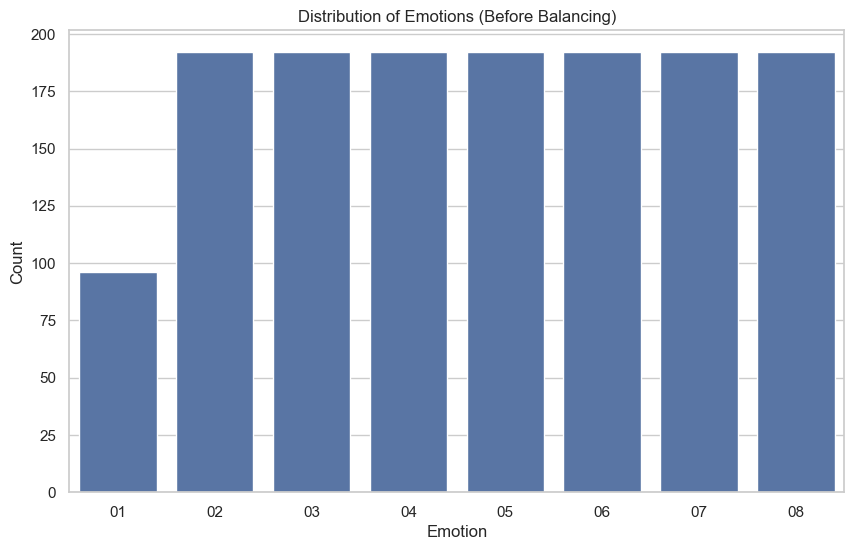

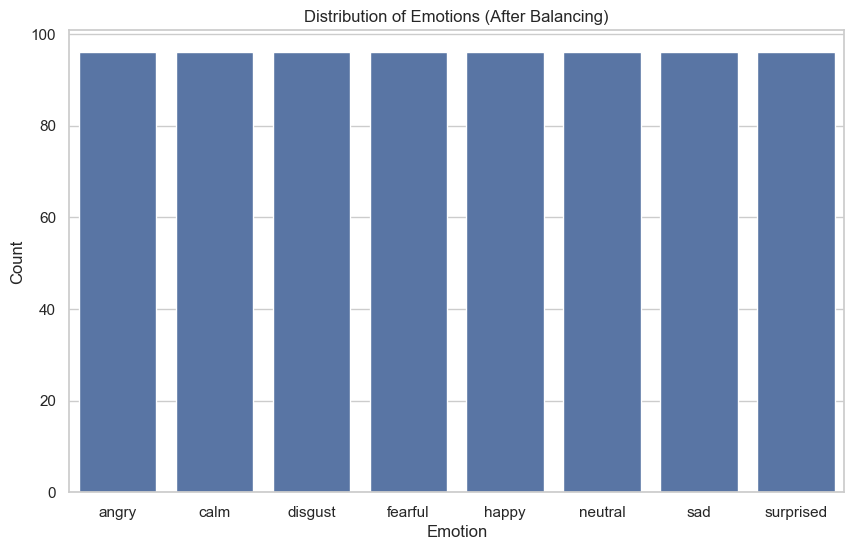

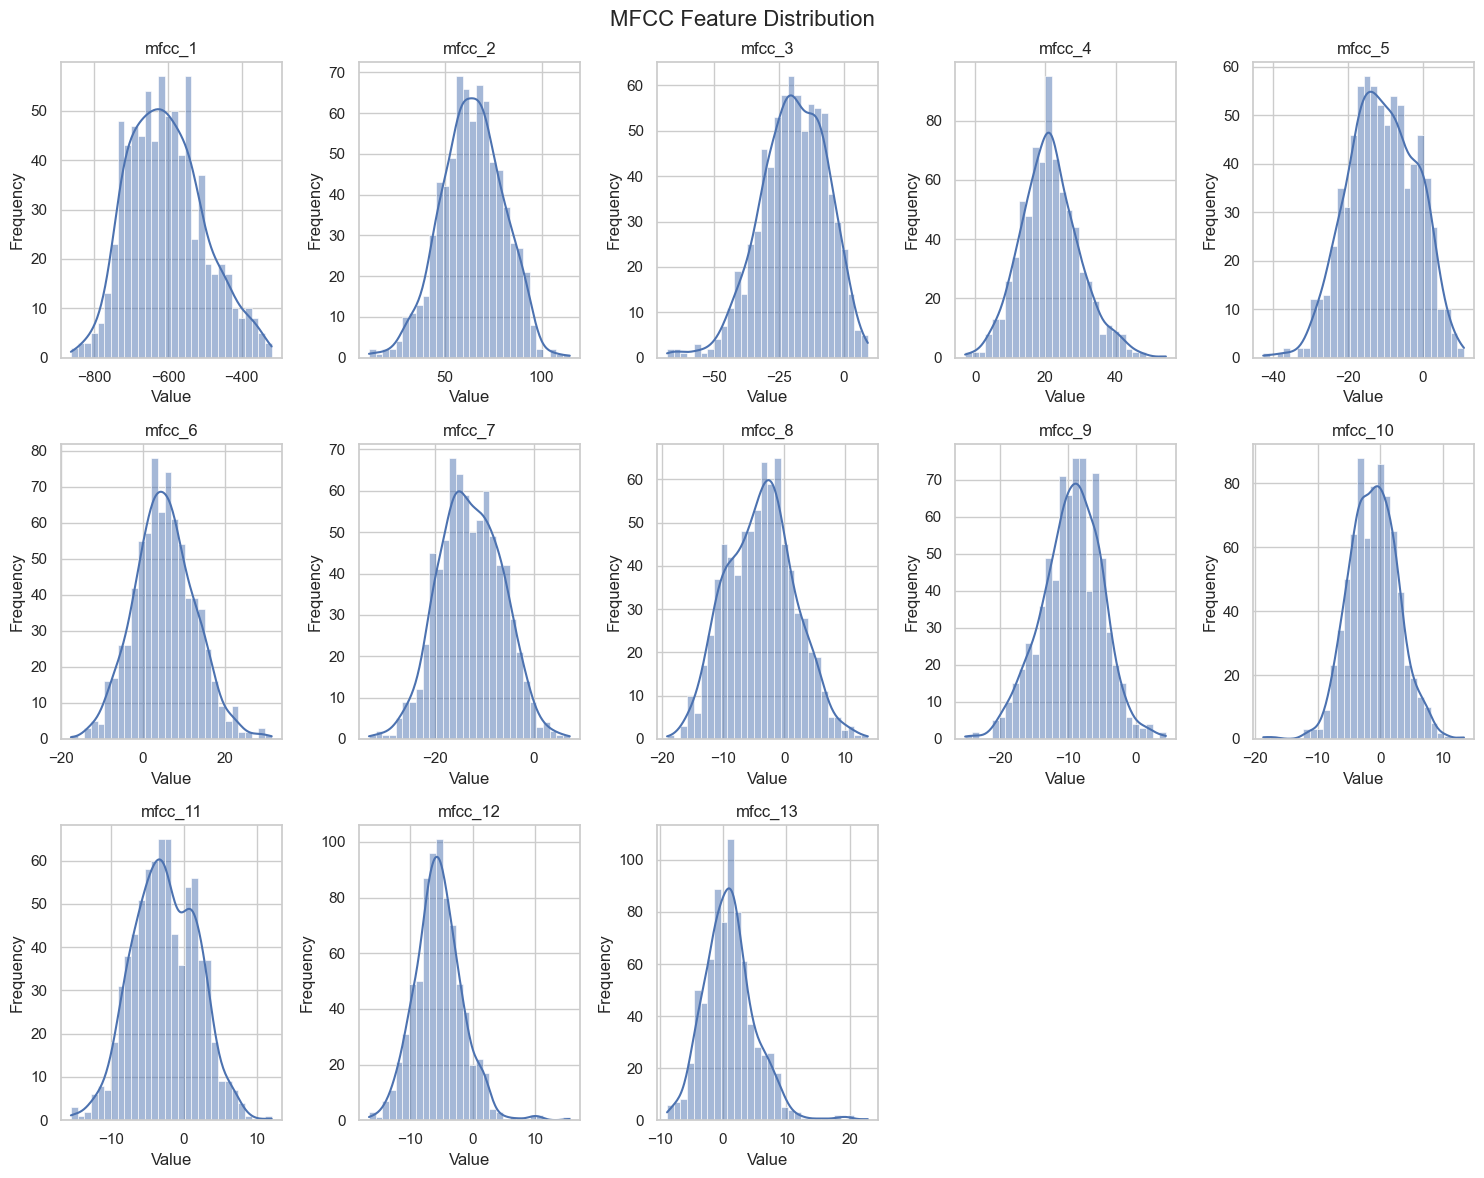

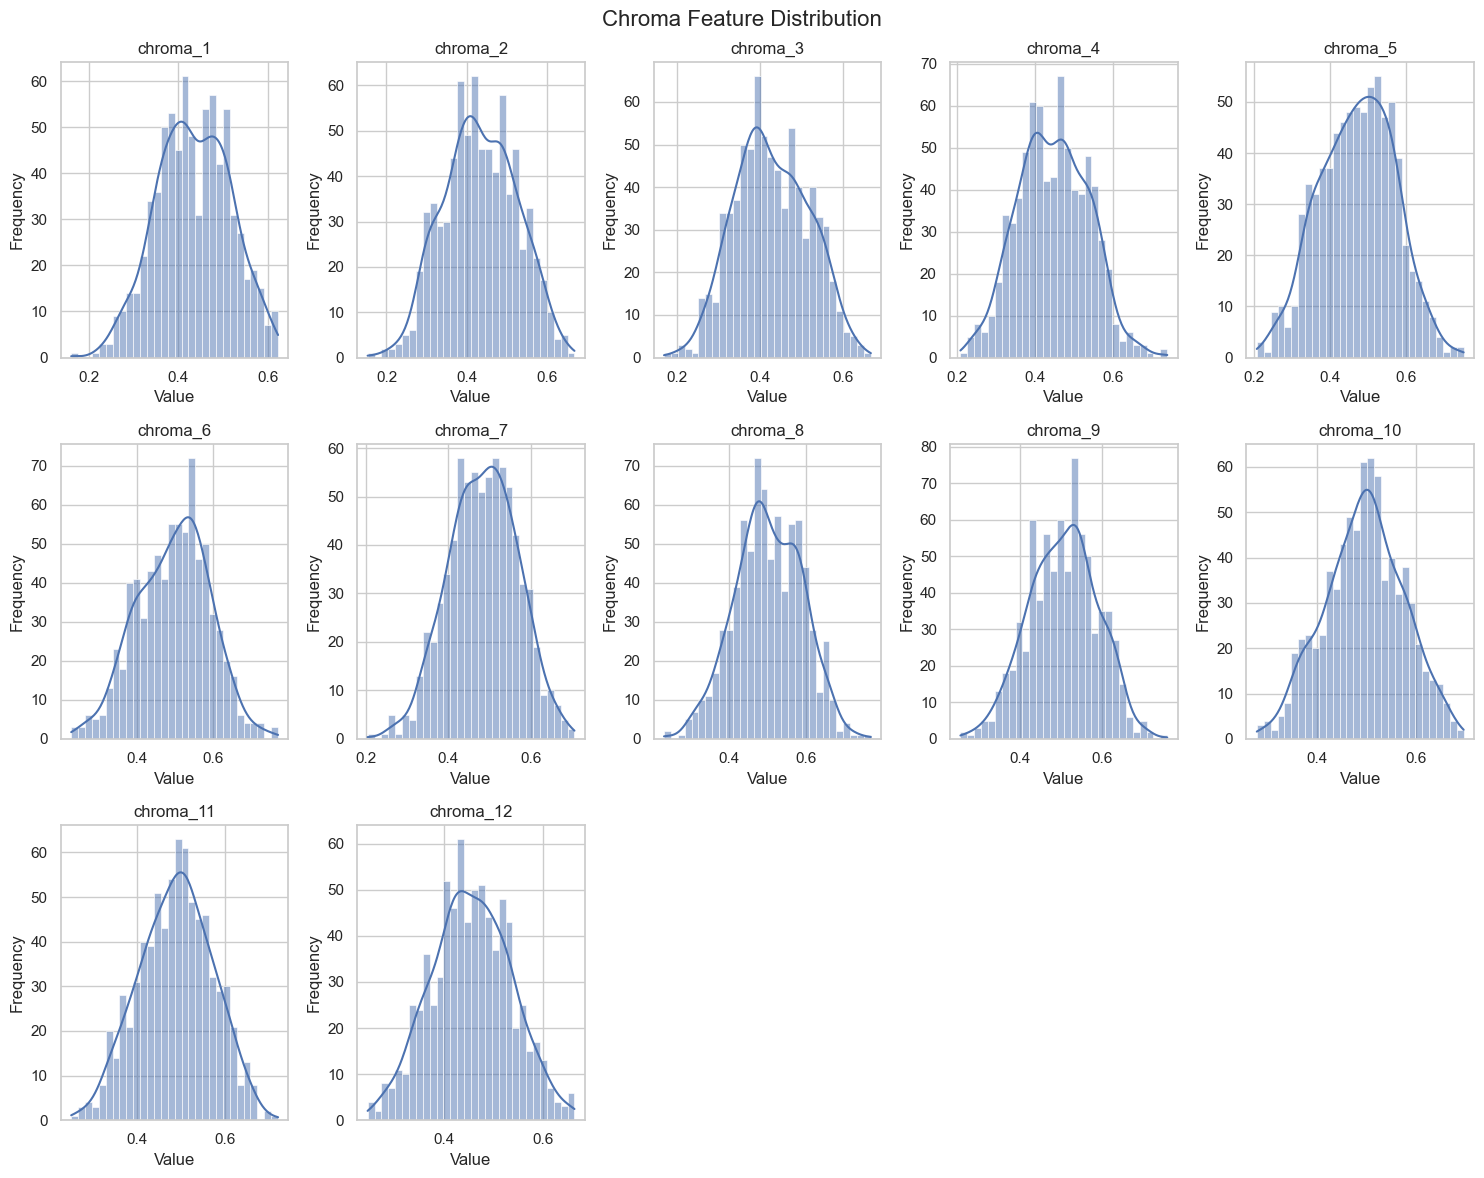

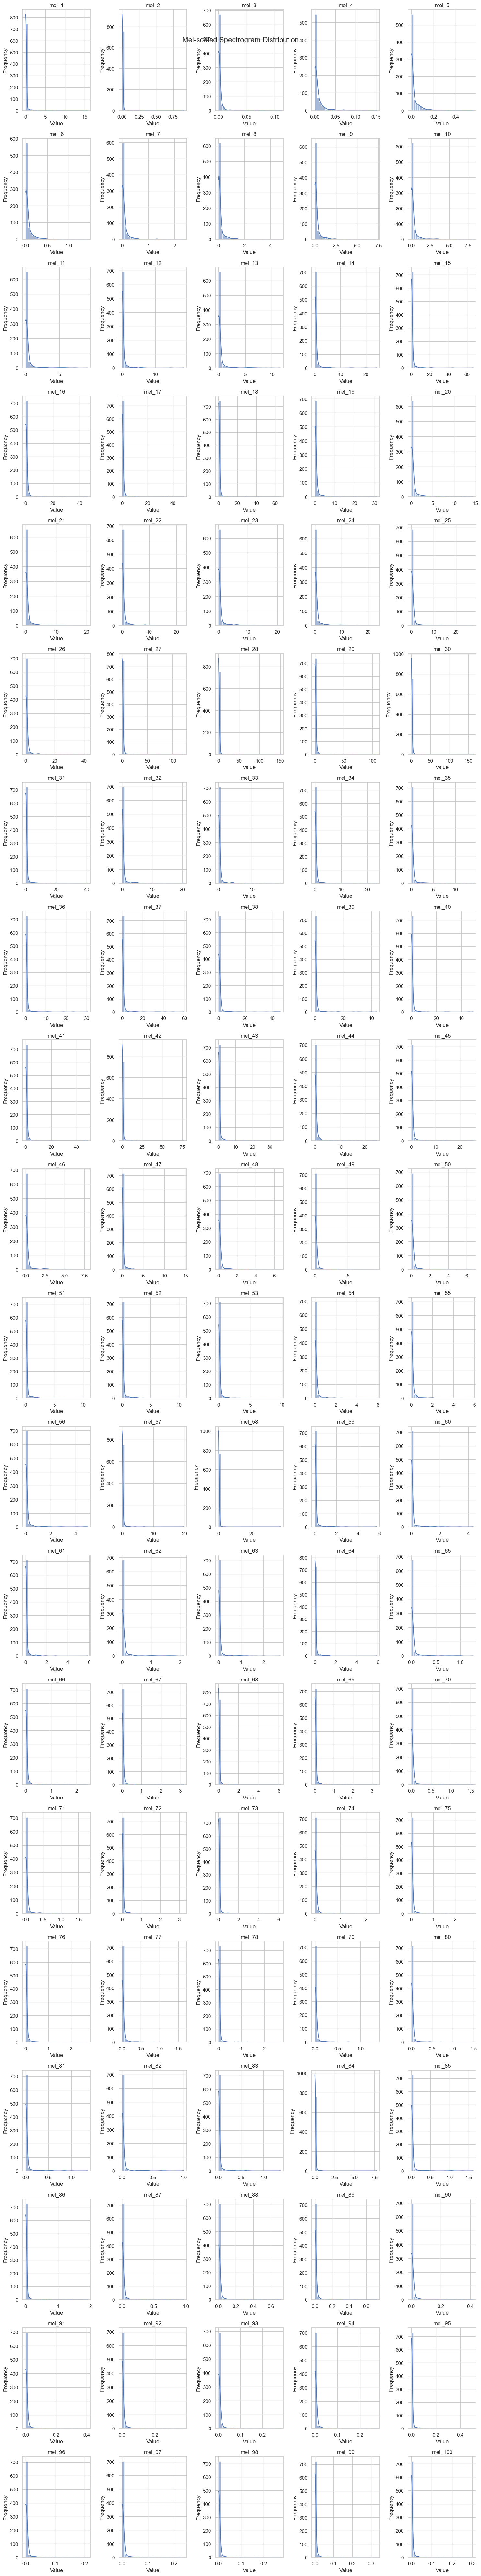

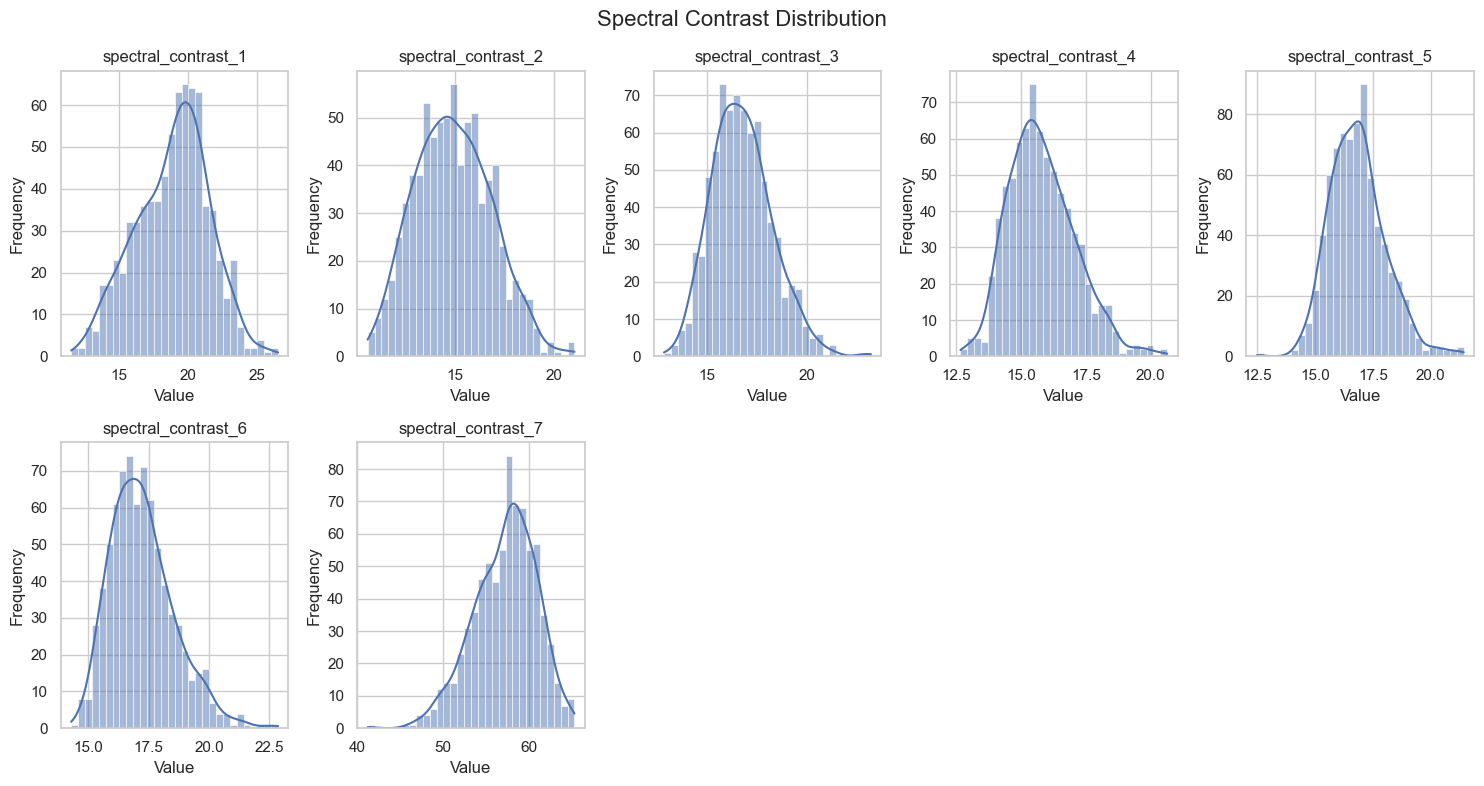

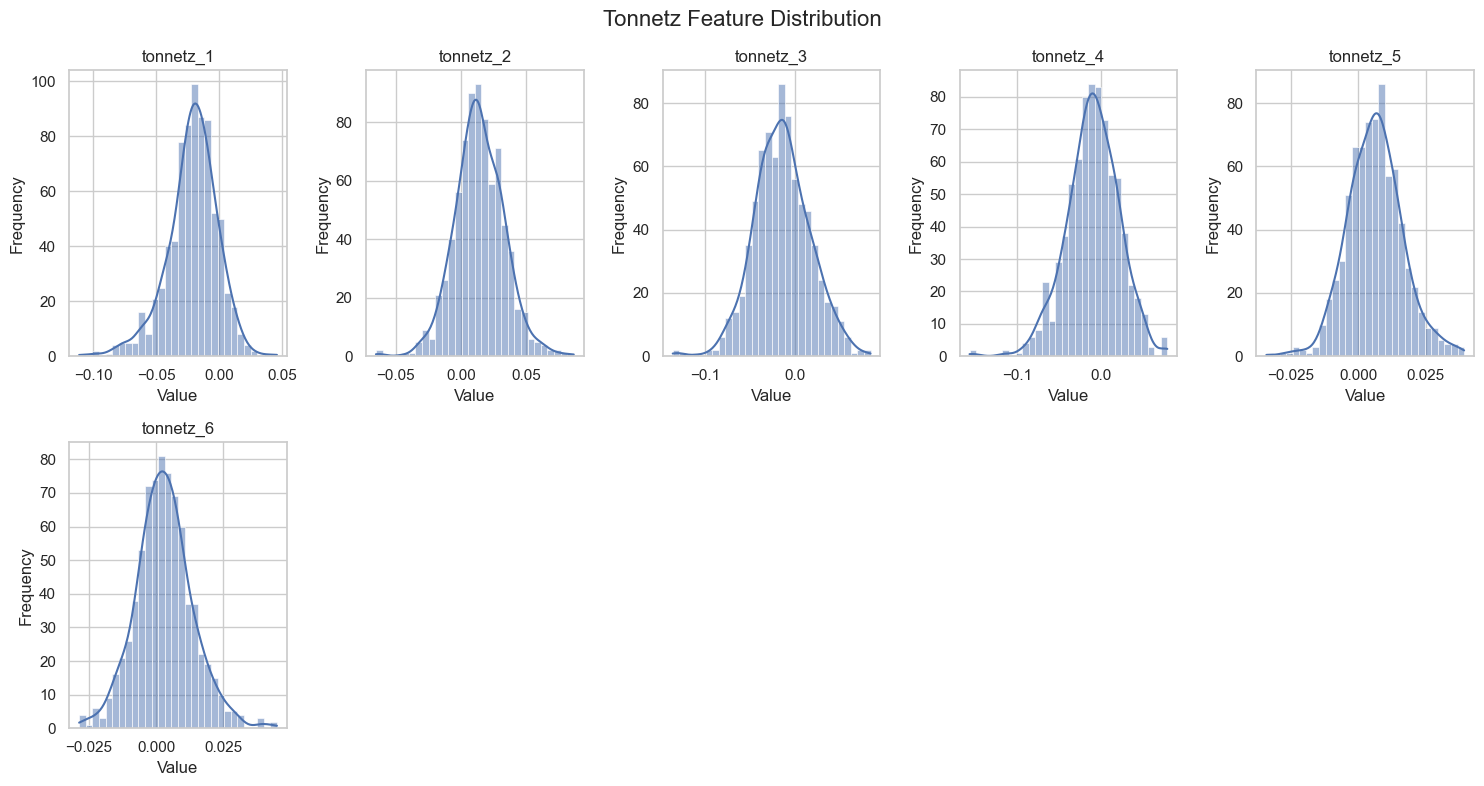

In [62]:
# Load the balanced dataset from the CSV
df_balanced = pd.read_csv('balanced_audio_features.csv')

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Function to plot histograms for features
def plot_feature_distribution(data, feature_names, title):
    num_features = len(feature_names)
    cols = 5  # Number of columns for subplots
    rows = (num_features + cols - 1) // cols  # Ceiling division to handle odd numbers

    plt.figure(figsize=(15, 4 * rows))  # Adjust height based on the number of rows
    for i, feature in enumerate(feature_names):
        plt.subplot(rows, cols, i + 1)  # Use calculated rows and cols
        sns.histplot(data[feature], kde=True, bins=30,)
        plt.title(feature)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the distribution of emotions before balancing
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=df_features)  
plt.title('Distribution of Emotions (Before Balancing)')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of emotions after balancing
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=balanced_df)
plt.title('Distribution of Emotions (After Balancing)')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Extract feature names for plotting
mfcc_features = [f'mfcc_{i+1}' for i in range(13)]
chroma_features = [f'chroma_{i+1}' for i in range(12)]
mel_features = [f'mel_{i+1}' for i in range(100)]  # Assuming 100 mel bands
spectral_contrast_features = [f'spectral_contrast_{i+1}' for i in range(7)]
tonnetz_features = [f'tonnetz_{i+1}' for i in range(6)]

# Plotting distributions for each feature set
plot_feature_distribution(balanced_df, mfcc_features, 'MFCC Feature Distribution')
plot_feature_distribution(balanced_df, chroma_features, 'Chroma Feature Distribution')
plot_feature_distribution(balanced_df, mel_features, 'Mel-scaled Spectrogram Distribution')
plot_feature_distribution(balanced_df, spectral_contrast_features, 'Spectral Contrast Distribution')
plot_feature_distribution(balanced_df, tonnetz_features, 'Tonnetz Feature Distribution')




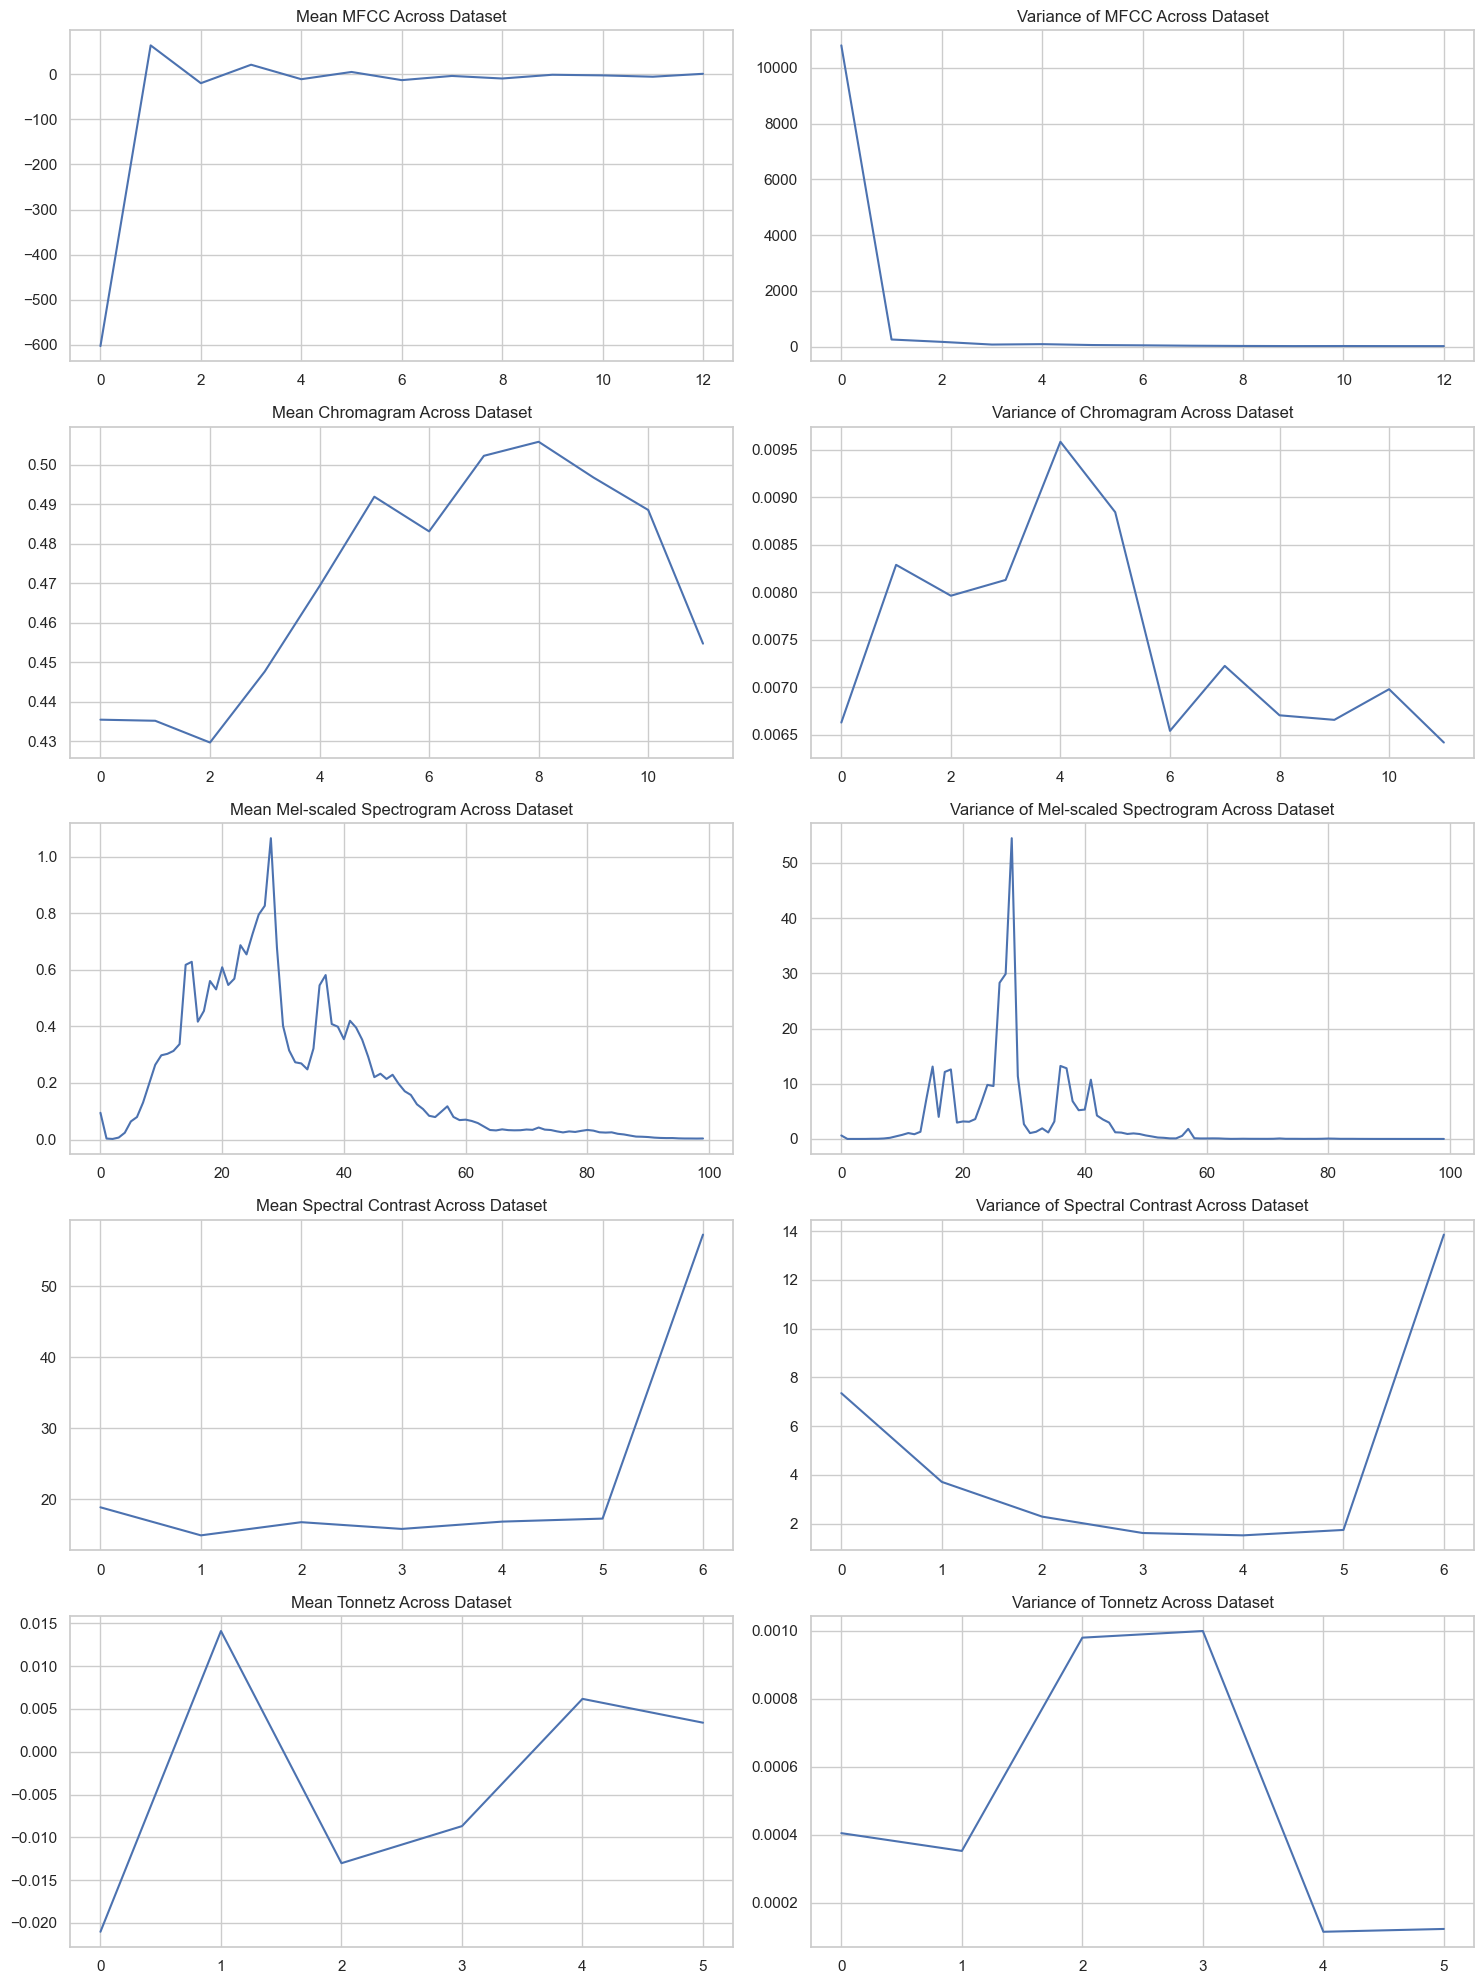

In [64]:
# Load the balanced dataset from the CSV
df_balanced = pd.read_csv('balanced_audio_features.csv')

# Extract features into NumPy arrays (assuming they are named accordingly)
mfcc = df_balanced[[f'mfcc_{i+1}' for i in range(13)]].values  # 13 MFCC features
chromagram = df_balanced[[f'chroma_{i+1}' for i in range(12)]].values  # 12 Chroma features
spectrogram = df_balanced[[f'mel_{i+1}' for i in range(100)]].values  # 100 Mel-scaled features
spectral_contrast = df_balanced[[f'spectral_contrast_{i+1}' for i in range(7)]].values  # 7 Spectral Contrast features
tonnetz = df_balanced[[f'tonnetz_{i+1}' for i in range(6)]].values  # 6 Tonnetz features

# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

# Plot MFCC mean and variance
axs[0, 0].plot(np.mean(mfcc, axis=0))
axs[0, 0].set_title('Mean MFCC Across Dataset')

axs[0, 1].plot(np.var(mfcc, axis=0))
axs[0, 1].set_title('Variance of MFCC Across Dataset')

# Plot Chromagram mean and variance
axs[1, 0].plot(np.mean(chromagram, axis=0))
axs[1, 0].set_title('Mean Chromagram Across Dataset')

axs[1, 1].plot(np.var(chromagram, axis=0))
axs[1, 1].set_title('Variance of Chromagram Across Dataset')

# Plot Mel-scaled Spectrogram mean and variance
axs[2, 0].plot(np.mean(spectrogram, axis=0))
axs[2, 0].set_title('Mean Mel-scaled Spectrogram Across Dataset')

axs[2, 1].plot(np.var(spectrogram, axis=0))
axs[2, 1].set_title('Variance of Mel-scaled Spectrogram Across Dataset')

# Plot Spectral Contrast mean and variance
axs[3, 0].plot(np.mean(spectral_contrast, axis=0))
axs[3, 0].set_title('Mean Spectral Contrast Across Dataset')

axs[3, 1].plot(np.var(spectral_contrast, axis=0))
axs[3, 1].set_title('Variance of Spectral Contrast Across Dataset')

# Plot Tonnetz mean and variance
axs[4, 0].plot(np.mean(tonnetz, axis=0))
axs[4, 0].set_title('Mean Tonnetz Across Dataset')

axs[4, 1].plot(np.var(tonnetz, axis=0))
axs[4, 1].set_title('Variance of Tonnetz Across Dataset')

plt.tight_layout()
plt.show()


7. Encoding Labels and Standardizing Features

In [49]:
# Load the balanced dataset from the CSV
df_balanced = pd.read_csv('balanced_audio_features.csv')

# Assume 'Emotion' is the column name containing the emotion labels
emotion_labels = df_balanced['Emotion']

# Convert emotion labels to numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(emotion_labels)

# Add the encoded labels to the DataFrame
df_balanced['Encoded_Emotion'] = encoded_labels

#Standardize the features 
feature_columns = df_balanced.columns.difference(['Actor', 'Audio_File', 'Emotion', 'Encoded_Emotion'])

scaler = StandardScaler()
df_balanced[feature_columns] = scaler.fit_transform(df_balanced[feature_columns])

print(df_balanced.columns) 
print(df_balanced.head())


Index(['Actor', 'Audio_File', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5',
       'mfcc_6', 'mfcc_7', 'mfcc_8',
       ...
       'spectral_contrast_6', 'spectral_contrast_7', 'tonnetz_1', 'tonnetz_2',
       'tonnetz_3', 'tonnetz_4', 'tonnetz_5', 'tonnetz_6', 'Emotion',
       'Encoded_Emotion'],
      dtype='object', length=170)
      Actor                Audio_File    mfcc_1    mfcc_2    mfcc_3    mfcc_4  \
0  Actor_17  03-01-01-01-02-01-17.wav -0.395122  1.245188  1.225605  0.867008   
1  Actor_09  03-01-01-01-02-02-09.wav -1.571343  1.232680  1.466428  1.417972   
2  Actor_08  03-01-01-01-01-02-08.wav -0.828070  1.083494  1.127947  1.449953   
3  Actor_09  03-01-01-01-02-01-09.wav -1.616885  1.170378  1.383839  1.747463   
4  Actor_22  03-01-01-01-01-01-22.wav -1.057463  0.533180  0.327070  0.077409   

     mfcc_5    mfcc_6    mfcc_7    mfcc_8  ...  spectral_contrast_6  \
0  1.527566  1.167259  2.647601  0.738935  ...             0.498177   
1  1.289768  1.059772  1.194713  

8. Building the MLP Model

In [50]:
# Load the balanced dataset from the CSV
df_balanced = pd.read_csv('balanced_audio_features.csv')

# Prepare features and labels
columns_to_drop = ['Actor', 'Audio_File', 'Encoded_Emotion']  
existing_columns_to_drop = [col for col in columns_to_drop if col in df_balanced.columns]
X = df_balanced.drop(columns=existing_columns_to_drop)  # Features
y = df_balanced['Emotion']  # Target variable

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the Basic MLPClassifier
mlp_model = MLPClassifier(random_state=42, max_iter=300)  
mlp_model.fit(X_train, y_train)


MLPClassifier(max_iter=300, random_state=42)

9. Fine-Tuning Hyperparameters

In [51]:
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': np.logspace(-5, 0, 6),  
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 500]
}

random_search = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='accuracy',  
    cv=3, 
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit the model with the best parameters
random_search.fit(X_train, y_train)

# Get the best model and parameters
best_mlp_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


10. Making Predictions
11. Analysing Different Metrics

In [54]:
# Predictions using the Basic Model (after fitting)
y_pred_basic = mlp_model.predict(X_test)

# Evaluate Basic Model Performance
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print(f'Basic Model Test Set Accuracy: {accuracy_basic:.2f}')
print("Basic Model Classification Report:")
print(classification_report(y_test, y_pred_basic))
print("Basic Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_basic)) 




Basic Model Test Set Accuracy: 0.65
Basic Model Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.94      0.74        31
           2       0.77      0.45      0.57        44
           3       0.62      0.88      0.72        33
           4       0.93      0.58      0.71        45
           5       0.79      0.48      0.60        31
           6       0.55      0.88      0.68        52
           7       1.00      0.11      0.20        37
           8       0.60      0.91      0.73        35

    accuracy                           0.65       308
   macro avg       0.73      0.65      0.62       308
weighted avg       0.73      0.65      0.62       308

Basic Model Confusion Matrix:
[[29  1  1  0  0  0  0  0]
 [18 20  5  1  0  0  0  0]
 [ 0  1 29  1  1  1  0  0]
 [ 0  4  7 26  0  8  0  0]
 [ 0  0  3  0 15 13  0  0]
 [ 0  0  2  0  3 46  0  1]
 [ 0  0  0  0  0 13  4 20]
 [ 0  0  0  0  0  3  0 32]]


In [55]:
# Predictions using the Optimized Model (after fitting)
y_pred_optimized = best_mlp_model.predict(X_test)

# Evaluate Optimized Model Performance
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f'Optimized Model Test Set Accuracy: {accuracy_optimized:.2f}')
print("Optimized Model Classification Report:")
print(classification_report(y_test, y_pred_optimized))
print("Optimized Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimized))

Optimized Model Test Set Accuracy: 0.92
Optimized Model Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        31
           2       1.00      0.98      0.99        44
           3       0.89      0.97      0.93        33
           4       1.00      0.91      0.95        45
           5       0.81      0.97      0.88        31
           6       0.95      0.77      0.85        52
           7       0.81      0.95      0.88        37
           8       0.94      0.91      0.93        35

    accuracy                           0.92       308
   macro avg       0.92      0.93      0.92       308
weighted avg       0.93      0.92      0.92       308

Optimized Model Confusion Matrix:
[[31  0  0  0  0  0  0  0]
 [ 1 43  0  0  0  0  0  0]
 [ 0  0 32  0  1  0  0  0]
 [ 0  0  4 41  0  0  0  0]
 [ 0  0  0  0 30  1  0  0]
 [ 0  0  0  0  6 40  5  1]
 [ 0  0  0  0  0  1 35  1]
 [ 0  0  0  0  0  0  3 32]]


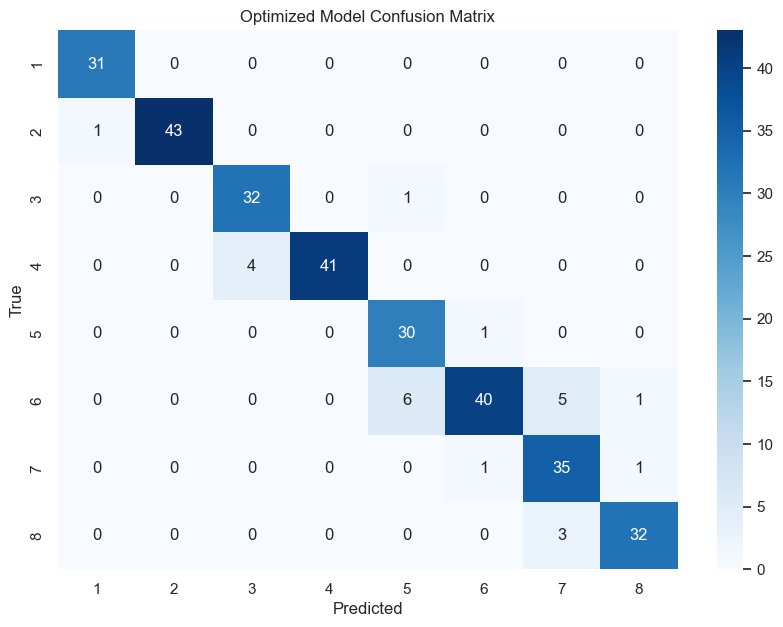

In [63]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix for optimized model
cm_opt = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Optimized Model Confusion Matrix')
plt.show()


12. Implemennting K-Fold Cross-Validation Techniques

In [57]:
# Define the number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the basic model
mlp_basic = MLPClassifier(random_state=42, max_iter=300)

# Perform K-fold cross-validation and predict on each fold
y_pred_basic_cv = cross_val_predict(mlp_basic, X, y, cv=kf)

# Calculate accuracy for each fold
cv_scores_basic = cross_val_score(mlp_basic, X, y, cv=kf, scoring='accuracy')

# Output the results of cross-validation
print(f"Basic Model Cross-Validation Accuracy Scores: {cv_scores_basic}")
print(f"Mean Accuracy: {cv_scores_basic.mean():.2f}")
print(f"Standard Deviation of Accuracy: {cv_scores_basic.std():.2f}")

# Calculate precision, recall, F1-score, and support for the basic model
precision_basic, recall_basic, f1_basic, _ = precision_recall_fscore_support(y, y_pred_basic_cv, average='weighted')

# Output precision, recall, and F1-score
print(f"\nBasic Model Precision (weighted): {precision_basic:.2f}")
print(f"Basic Model Recall (weighted): {recall_basic:.2f}")
print(f"Basic Model F1-score (weighted): {f1_basic:.2f}")

# Display the confusion matrix for the basic model
confusion_mat_basic = confusion_matrix(y, y_pred_basic_cv)
print("\nBasic Model Confusion Matrix (Aggregated over all folds):")
print(confusion_mat_basic)

# Display classification report for the basic model
print("\nBasic Model Classification Report (Aggregated over all folds):")
print(classification_report(y, y_pred_basic_cv))

Basic Model Cross-Validation Accuracy Scores: [0.62987013 0.65798046 0.66123779 0.66449511 0.60586319]
Mean Accuracy: 0.64
Standard Deviation of Accuracy: 0.02

Basic Model Precision (weighted): 0.65
Basic Model Recall (weighted): 0.64
Basic Model F1-score (weighted): 0.63

Basic Model Confusion Matrix (Aggregated over all folds):
[[112  64  16   0   0   0   0   0]
 [ 42 119  24   7   0   0   0   0]
 [  5  13 148   7  13   6   0   0]
 [ 20  47  33  63  16  12   1   0]
 [  0   0  13   2 146  14  17   0]
 [  0   0   9  11  19 115  25  13]
 [  0   0   0   0  11   9 110  62]
 [  0   0   0   0   1   2  13 176]]

Basic Model Classification Report (Aggregated over all folds):
              precision    recall  f1-score   support

           1       0.63      0.58      0.60       192
           2       0.49      0.62      0.55       192
           3       0.61      0.77      0.68       192
           4       0.70      0.33      0.45       192
           5       0.71      0.76      0.73       1

13. Performing Comparative Study with Respect to SVM and KNN

In [59]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM classifier with increased regularization
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Train the model on the entire training set
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Test Set Accuracy: {accuracy_svm:.2f}')

# Display confusion matrix and classification report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm)) 

Cross-validation scores: [0.69105691 0.70731707 0.68699187 0.73061224 0.63265306]
Mean CV score: 0.69 (+/- 0.06)
SVM Test Set Accuracy: 0.71
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.81      0.81        31
           2       0.75      0.86      0.80        44
           3       0.85      0.85      0.85        33
           4       0.75      0.67      0.71        45
           5       0.63      0.61      0.62        31
           6       0.60      0.35      0.44        52
           7       0.56      0.78      0.65        37
           8       0.80      0.94      0.87        35

    accuracy                           0.71       308
   macro avg       0.72      0.73      0.72       308
weighted avg       0.71      0.71      0.70       308

SVM Confusion Matrix:
[[25  6  0  0  0  0  0  0]
 [ 5 38  0  1  0  0  0  0]
 [ 1  2 28  1  1  0  0  0]
 [ 0  5  1 30  0  9  0  0]
 [ 0  0  3  3 19  1  5  0]
 [ 0  0  1  5 10 18 16  

In [60]:
# Scale the features (assuming X_train and X_test are defined)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed

# Perform cross-validation
cv_scores_knn = cross_val_score(knn_model, X_train_scaled, y_train, cv=5)
print(f"KNN Cross-validation scores: {cv_scores_knn}")
print(f"Mean KNN CV score: {cv_scores_knn.mean():.2f} (+/- {cv_scores_knn.std() * 2:.2f})")

# Train the model on the entire training set
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Test Set Accuracy: {accuracy_knn:.2f}')

# Display confusion matrix and classification report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Cross-validation scores: [0.62195122 0.6097561  0.54878049 0.57142857 0.57142857]
Mean KNN CV score: 0.58 (+/- 0.05)
KNN Test Set Accuracy: 0.59
KNN Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.94      0.67        31
           2       0.76      0.66      0.71        44
           3       0.58      0.58      0.58        33
           4       0.81      0.58      0.68        45
           5       0.40      0.52      0.45        31
           6       0.60      0.35      0.44        52
           7       0.48      0.57      0.52        37
           8       0.71      0.71      0.71        35

    accuracy                           0.59       308
   macro avg       0.61      0.61      0.59       308
weighted avg       0.62      0.59      0.59       308

KNN Confusion Matrix:
[[29  0  2  0  0  0  0  0]
 [14 29  0  0  1  0  0  0]
 [ 4  1 19  1  5  1  2  0]
 [ 4  6  2 26  3  3  1  0]
 [ 1  0  2  1 16  3  6  2]
 [ 2  0  8  3  7

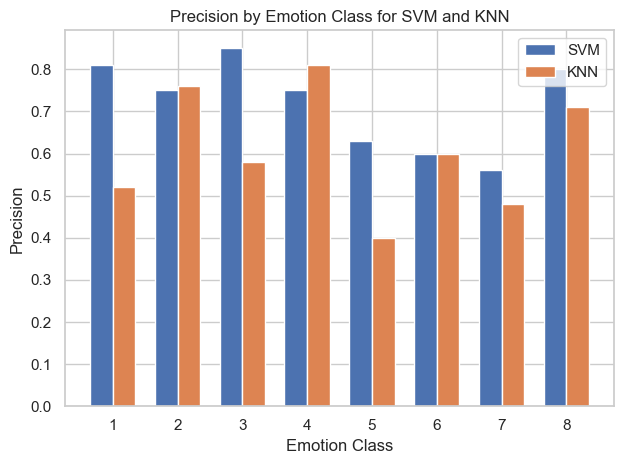

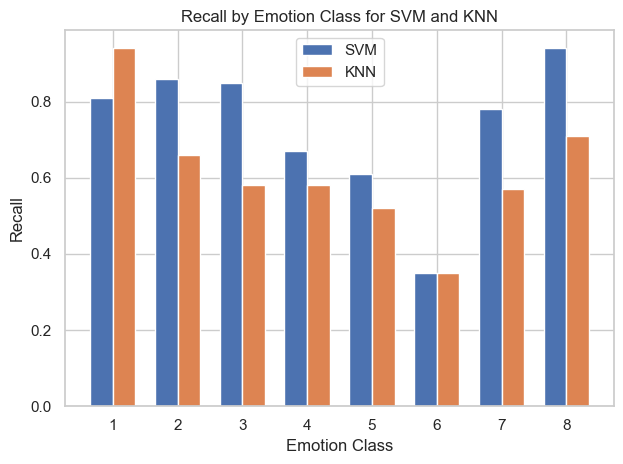

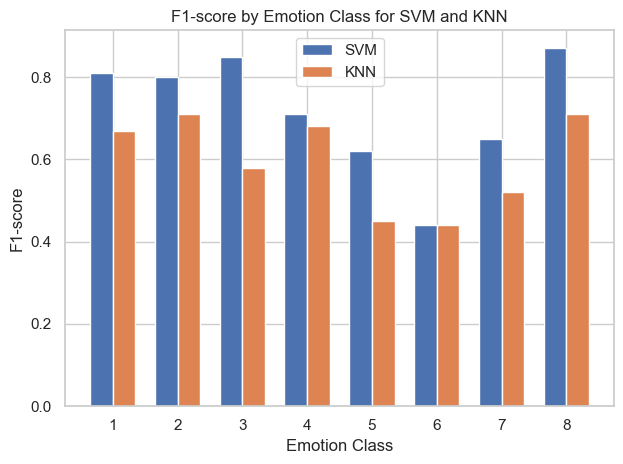

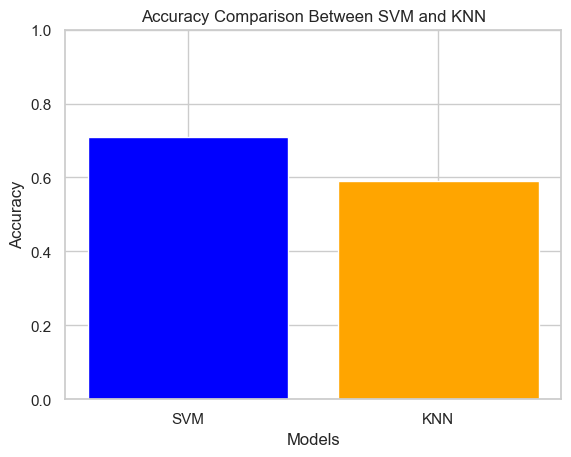

In [65]:
# Metrics for SVM and KNN (from results)
svm_metrics = {
    'accuracy': 0.71,
    'precision': [0.81, 0.75, 0.85, 0.75, 0.63, 0.60, 0.56, 0.80],
    'recall':    [0.81, 0.86, 0.85, 0.67, 0.61, 0.35, 0.78, 0.94],
    'f1-score':  [0.81, 0.80, 0.85, 0.71, 0.62, 0.44, 0.65, 0.87]
}

knn_metrics = {
    'accuracy': 0.59,
    'precision': [0.52, 0.76, 0.58, 0.81, 0.40, 0.60, 0.48, 0.71],
    'recall':    [0.94, 0.66, 0.58, 0.58, 0.52, 0.35, 0.57, 0.71],
    'f1-score':  [0.67, 0.71, 0.58, 0.68, 0.45, 0.44, 0.52, 0.71]
}

# Labels for emotions (1 to 8)
labels = ['1', '2', '3', '4', '5', '6', '7', '8']

# Function to plot the metrics
def plot_metrics(metric_name, svm_values, knn_values, labels):
    x = np.arange(len(labels))  # label locations
    width = 0.35  # bar width

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, svm_values, width, label='SVM')
    rects2 = ax.bar(x + width/2, knn_values, width, label='KNN')

    # Add some text for labels, title, and axes ticks
    ax.set_xlabel('Emotion Class')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Emotion Class for SVM and KNN')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Plot Precision
plot_metrics('Precision', svm_metrics['precision'], knn_metrics['precision'], labels)

# Plot Recall
plot_metrics('Recall', svm_metrics['recall'], knn_metrics['recall'], labels)

# Plot F1-score
plot_metrics('F1-score', svm_metrics['f1-score'], knn_metrics['f1-score'], labels)

# Plot Accuracy Comparison as a single bar graph
def plot_accuracy(svm_acc, knn_acc):
    models = ['SVM', 'KNN']
    accuracy = [svm_acc, knn_acc]

    plt.bar(models, accuracy, color=['blue', 'orange'])
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison Between SVM and KNN')
    plt.ylim([0, 1])  # setting y-axis limits from 0 to 1
    plt.show()

# Plot Accuracy
plot_accuracy(svm_metrics['accuracy'], knn_metrics['accuracy'])


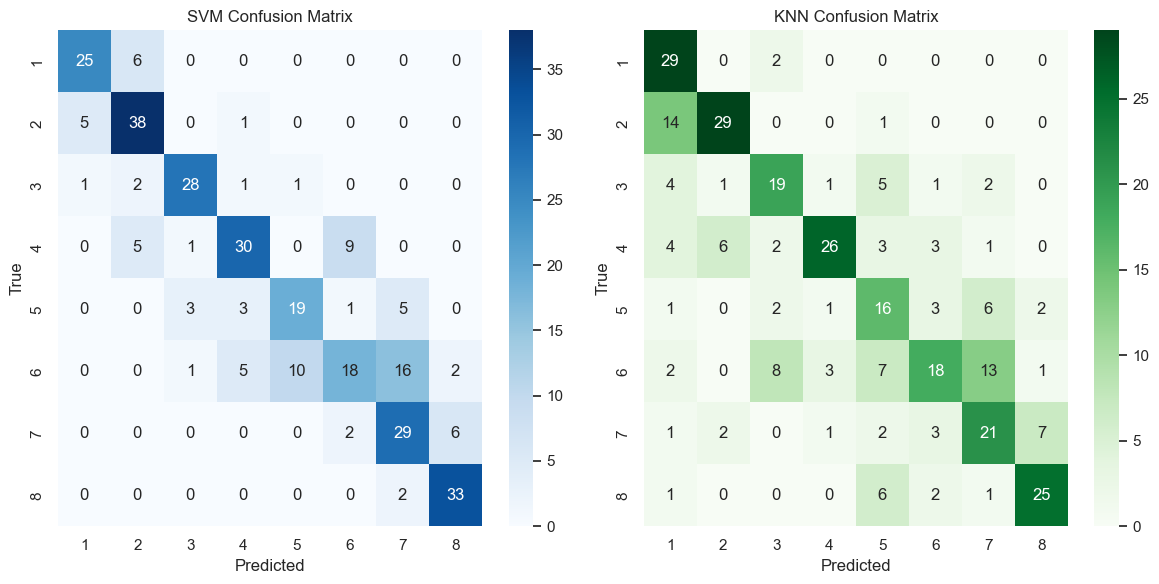

In [66]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot SVM Confusion Matrix
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Position the first plot
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot KNN Confusion Matrix
plt.subplot(1, 2, 2)  # Position the second plot
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
